In [6]:

path ='/content/drive/MyDrive/DL/cinic-10'
best_model_path = '/content/drive/MyDrive/DL/best_model.pth'
exp_logs_path = "./drive/MyDrive/DL/experiment_logs"
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("mengcius/cinic10")

In [2]:
# Tool Classification System using Deep Feedforward Networks
# Solution-based learning implementation for CINIC-10 dataset

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class ToolClassificationDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):  # Add split parameter
        self.root_dir = root_dir
        self.split = split  # Only load specified split
        self.transform = transform
        self.classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        print(f"Entering _load_samples for split: {self.split}") # Added print
        # Only load from specified split
        subdir_path = os.path.join(self.root_dir, self.split)

        if os.path.exists(subdir_path):
            for class_name in self.classes:
                class_dir = os.path.join(subdir_path, class_name)
                if os.path.exists(class_dir):
                    for img_name in os.listdir(class_dir):
                        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                            img_path = os.path.join(class_dir, img_name)
                            samples.append((img_path, self.class_to_idx[class_name]))
                else:
                    print(f"Class_dir does not exist: {class_dir}") # Added print
        else:
            print(f"Subdir_path does not exist: {subdir_path}") # Added print

        print(f"Finished _load_samples for split: {self.split}. Found {len(samples)} samples.") # Added print
        return samples


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

class DeepFeedforwardNetwork(nn.Module):
    """
    Deep Feedforward Network for image classification

    Architecture explanation:
    - Fully connected layers with ReLU activations
    - Dropout for regularization
    - Batch normalization for training stability
    """

    def __init__(self, input_size=32*32*3, hidden_sizes=[1024, 512, 256],
                 num_classes=10, dropout_rate=0.5):
        super(DeepFeedforwardNetwork, self).__init__()

        # Store architecture info
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes

        # Build layers dynamically
        layers = []
        prev_size = input_size

        # Hidden layers
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),  # Batch normalization
                nn.ReLU(),                    # Activation function
                nn.Dropout(dropout_rate)      # Regularization
            ])
            prev_size = hidden_size

        # Output layer (no activation - will use CrossEntropyLoss)
        layers.append(nn.Linear(prev_size, num_classes))

        self.network = nn.Sequential(*layers)

        # Initialize weights using Xavier/Glorot initialization
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize network weights for better training"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)

    def forward(self, x):
        """Forward pass through the network"""
        # Flatten the input (batch_size, channels, height, width) -> (batch_size, features)
        x = x.view(x.size(0), -1)
        return self.network(x)

class ToolClassifier:
    """Main class for training and evaluating the tool classification system"""

    def __init__(self, model_params=None):
        # Set device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        # Initialize model
        if model_params is None:
            model_params = {
                'hidden_sizes': [512, 256, 128], #check
                'dropout_rate': 0.3
            }

        self.model = DeepFeedforwardNetwork(**model_params).to(self.device)

        # Training history
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

        # Class names for CINIC-10 (representing tool categories)
        self.class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                           'dog', 'frog', 'horse', 'ship', 'truck']

    def prepare_data(self, data_dir, batch_size=128, val_split=0.2, subset_fraction=1.0):
          """Prepare data loaders with appropriate transforms, optionally using a subset"""
          print("Preparing data...") # Debugging statement
          # Data transformations
          train_transform = transforms.Compose([
              transforms.Resize((32, 32)),
              transforms.RandomHorizontalFlip(p=0.5),  # Data augmentation
              transforms.RandomRotation(10),            # Data augmentation
              transforms.ToTensor(),
              transforms.Normalize(mean=[0.47889522, 0.47227842, 0.43047404],
                                std=[0.24205776, 0.23828046, 0.25874835]),

          ])

          val_transform = transforms.Compose([
              transforms.Resize((32, 32)),
              transforms.ToTensor(),
              transforms.Normalize(mean=[0.47889522, 0.47227842, 0.43047404],
                                std=[0.24205776, 0.23828046, 0.25874835])

          ])

          # Load the full dataset first
          full_train_dataset = ToolClassificationDataset(data_dir, split='train', transform=train_transform)
          full_val_dataset = ToolClassificationDataset(data_dir, split='valid', transform=val_transform)


          # Apply subsetting if subset_fraction is less than 1.0
          if subset_fraction < 1.0:
              print(f"Using {subset_fraction*100}% of data for quick test.") # Debugging statement
              train_size = int(len(full_train_dataset) * subset_fraction)
              val_size = int(len(full_val_dataset) * subset_fraction)

              # Ensure sizes are at least 1 if the original dataset is not empty
              train_size = max(1, train_size) if len(full_train_dataset) > 0 else 0
              val_size = max(1, val_size) if len(full_val_dataset) > 0 else 0


              # Use random_split to get a subset of the original train and validation sets
              # This is a simpler approach than creating a combined dataset and then splitting
              train_dataset, _ = random_split(full_train_dataset, [train_size, len(full_train_dataset) - train_size])
              val_dataset, _ = random_split(full_val_dataset, [val_size, len(full_val_dataset) - val_size])

              print(f"Subset Train dataset size: {len(train_dataset)}")
              print(f"Subset Val dataset size: {len(val_dataset)}")

          else:
              # Use the full datasets
              print("Using full dataset.") # Debugging statement
              train_dataset = full_train_dataset
              val_dataset = full_val_dataset
              print(f"Full Train dataset size: {len(train_dataset)}")
              print(f"Full Val dataset size: {len(val_dataset)}")


          # Create data loaders
          self.train_loader = DataLoader(train_dataset, batch_size=batch_size,
                                      shuffle=True, num_workers=2)
          self.val_loader = DataLoader(val_dataset, batch_size=batch_size,
                                    shuffle=False, num_workers=2, pin_memory=True)

          print(f"Training samples in loader: {len(train_dataset)}") # Debugging statement
          print(f"Validation samples in loader: {len(val_dataset)}") # Debugging statement

          return self.train_loader, self.val_loader

    def train_epoch(self, optimizer, criterion):
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, targets) in enumerate(tqdm(self.train_loader, desc="Training")):
            data, targets = data.to(self.device), targets.to(self.device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = self.model(data)
            loss = criterion(outputs, targets)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100 * correct / total

        return epoch_loss, epoch_acc

    def validate_epoch(self, criterion):
        """Validate for one epoch"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, targets in tqdm(self.val_loader, desc="Validating"):
                data, targets = data.to(self.device), targets.to(self.device)

                outputs = self.model(data)
                loss = criterion(outputs, targets)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        epoch_loss = running_loss / len(self.val_loader)
        epoch_acc = 100 * correct / total

        return epoch_loss, epoch_acc

    def train(self, epochs=50, learning_rate=0.001, weight_decay=1e-4):
        """Complete training loop with gradient descent optimization"""

        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        # optimizer = optim.Adam(self.model.parameters(),
        #                      lr=learning_rate,
        #                      weight_decay=weight_decay)
        optimizer = optim.SGD(self.model.parameters(), lr=learning_rate, momentum=0.9)

        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',
                                                       patience=5, factor=0.5)

        best_val_acc = 0.0

        print("Starting training...")
        print("=" * 60)

        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")

            # Training
            train_loss, train_acc = self.train_epoch(optimizer, criterion)

            # Validation
            val_loss, val_acc = self.validate_epoch(criterion)

            # Update learning rate
            scheduler.step(val_loss)

            # Store history
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)

            # Print progress
            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_acc': val_acc,
                }, best_model_path)
                print(f"New best model saved! Val Acc: {val_acc:.2f}%")

            print("-" * 60)

        print(f"Training completed! Best validation accuracy: {best_val_acc:.2f}%")

    def evaluate_model(self):
        """Comprehensive model evaluation"""
        self.model.eval()
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for data, targets in tqdm(self.val_loader, desc="Evaluating"):
                data, targets = data.to(self.device), targets.to(self.device)
                outputs = self.model(data)
                _, predicted = torch.max(outputs, 1)

                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        # Classification report
        report = classification_report(all_targets, all_predictions,
                                     target_names=self.class_names,
                                     output_dict=True)

        # Print detailed results
        print("\nDetailed Classification Report:")
        print("=" * 60)
        print(classification_report(all_targets, all_predictions,
                                  target_names=self.class_names))

        return all_predictions, all_targets, report

    def plot_training_history(self):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Loss plot
        ax1.plot(self.train_losses, label='Training Loss', color='blue')
        ax1.plot(self.val_losses, label='Validation Loss', color='red')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        # Accuracy plot
        ax2.plot(self.train_accuracies, label='Training Accuracy', color='blue')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', color='red')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.savefig('/content/drive/MyDrive/DLtraining_history.png', dpi=300, bbox_inches='tight')
        plt.show()

    def plot_confusion_matrix(self, predictions, targets):
        """Plot confusion matrix"""
        cm = confusion_matrix(targets, predictions)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.class_names,
                   yticklabels=self.class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()

    def predict_single_image(self, image_path):
        """Predict category for a single image"""
        # Load and preprocess image
        transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(self.device)

        self.model.eval()
        with torch.no_grad():
            output = self.model(image_tensor)
            probabilities = F.softmax(output, dim=1)
            _, predicted = torch.max(output, 1)

            predicted_class = self.class_names[predicted.item()]
            confidence = probabilities[0][predicted.item()].item() * 100

        return predicted_class, confidence, probabilities[0].cpu().numpy()

In [5]:
# Demonstration and Analysis Functions
def demonstrate_math_concepts():
    """
    Demonstrate the mathematical concepts behind deep learning
    """
    print("MATHEMATICAL FOUNDATIONS OF DEEP LEARNING")
    print("=" * 60)

    # 1. Linear Transformation
    print("1. LINEAR TRANSFORMATION (Matrix Multiplication)")
    print("   Input: x = [x1, x2, x3]")
    print("   Weights: W = [[w11, w12, w13], [w21, w22, w23]]")
    print("   Output: y = W * x + b")
    print("   This transforms input features into new representations")
    print()

    # 2. Activation Functions
    print("2. ACTIVATION FUNCTIONS (Non-linearity)")
    x = np.linspace(-5, 5, 100)
    relu = np.maximum(0, x)
    sigmoid = 1 / (1 + np.exp(-x))

    print("   ReLU: f(x) = max(0, x) - introduces non-linearity")
    print("   Sigmoid: f(x) = 1/(1+e^(-x)) - squashes values to (0,1)")
    print("   Without activation functions, deep networks = linear regression!")
    print()

    # 3. Loss Function
    print("3. LOSS FUNCTION (Cross-Entropy)")
    print("   L = -Σ(y_true * log(y_pred))")
    print("   Measures difference between predicted and actual categories")
    print("   Guides the learning process")
    print()

    # 4. Gradient Descent
    print("4. GRADIENT DESCENT (Optimization)")
    print("   θ_new = θ_old - α * ∇L/∇θ")
    print("   θ: model parameters (weights)")
    print("   α: learning rate")
    print("   ∇L/∇θ: gradient (direction of steepest increase)")
    print("   We move OPPOSITE to gradient to minimize loss")
    print()

    # 5. Backpropagation
    print("5. BACKPROPAGATION (Chain Rule)")
    print("   ∂L/∂w1 = ∂L/∂y * ∂y/∂z * ∂z/∂w1")
    print("   Computes gradients layer by layer backwards")
    print("   Uses calculus chain rule efficiently")
    print()

def compare_approaches():
    """
    Compare different approaches for image classification
    """
    print("COMPARISON OF CLASSIFICATION APPROACHES")
    print("=" * 60)

    approaches = {
        "Traditional ML + Hand-crafted features": {
            "pros": ["Interpretable", "Fast training", "Less data needed"],
            "cons": ["Manual feature engineering", "Limited accuracy", "Not scalable"],
            "accuracy": "60-70%"
        },
        "Deep Feedforward Networks": {
            "pros": ["Automatic feature learning", "Good performance", "Flexible"],
            "cons": ["Treats pixels independently", "Many parameters", "Overfitting risk"],
            "accuracy": "70-80%"
        },
        "Convolutional Neural Networks": {
            "pros": ["Spatial awareness", "Translation invariant", "Hierarchical features"],
            "cons": ["More complex", "Computationally intensive"],
            "accuracy": "80-95%"
        }
    }

    for approach, details in approaches.items():
        print(f"\n{approach}:")
        print(f"  Typical Accuracy: {details['accuracy']}")
        print("  Pros:", ", ".join(details['pros']))
        print("  Cons:", ", ".join(details['cons']))



In [13]:
def test_run(data_path, subset_fraction=0.1, epochs=5, learning_rate=0.01):
    """
   Test run with subset of data for initial validation and logging

    Args:
        data_path: Path to CINIC-10 dataset
        subset_fraction: Fraction of data to use (0.1 = 10%)
        epochs: Number of training epochs
        learning_rate: Learning rate for the optimizer
    """
    print(f"🚀 TEST RUN - Using {subset_fraction*100}% of data")
    print(f"   Epochs: {epochs}, Learning Rate: {learning_rate}")
    print("=" * 60)

    # Initialize classifier
    print("Initializing ToolClassifier...")
    classifier = ToolClassifier()
    print("ToolClassifier initialized.")

    # Prepare data using the class method
    print("\nPreparing data...")
    train_loader, val_loader = classifier.prepare_data(
        data_path,
        batch_size=32, # You can adjust batch size here
        val_split=None, # Not needed when using split='train' and 'valid'
        subset_fraction=subset_fraction
    )
    print("Data preparation complete.")


    # Quick training run
    if classifier.train_loader is not None and classifier.val_loader is not None:
        print("\n🔥 Starting training...")
        classifier.train(epochs=epochs, learning_rate=learning_rate)
        print( "Training finished.")

        # evaluation
        print("\n📊 evaluation...")
        predictions, targets, report = classifier.evaluate_model()
        print( "Evaluation finished.")

        # Show results
        print("Plotting training history...")
        classifier.plot_training_history()
        print("Training history plotted.")

        print(f"\n✅ test completed!")
        print(f"Final validation accuracy: {classifier.val_accuracies[-1]:.2f}%")
        print(f"This was just {subset_fraction*100}% of data - expect higher accuracy with full dataset")

        # Log results
        log_results(epochs, learning_rate, classifier.train_losses, classifier.train_accuracies,
                    classifier.val_losses, classifier.val_accuracies, report)
        print("Results logged.")
    else:
        print("\nSkipping training and evaluation due to empty dataset loaders.")


    return classifier

def log_results(epochs, learning_rate, train_losses, train_accuracies, val_losses, val_accuracies, report):
    """Logs training and evaluation results to files"""
    log_dir = "./drive/MyDrive/DL/experiment_logs"
    os.makedirs(log_dir, exist_ok=True)

    # Create a unique filename for this run based on hyperparameters and timestamp
    timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
    log_prefix = f"lr_{learning_rate}_epochs_{epochs}_{timestamp}"

    # Log epoch-wise metrics to CSV
    csv_filepath = os.path.join(log_dir, f"{log_prefix}_training_history.csv")
    history_df = pd.DataFrame({
        'epoch': range(1, epochs + 1),
        'train_loss': train_losses,
        'train_accuracy': train_accuracies,
        'val_loss': val_losses,
        'val_accuracy': val_accuracies
    })
    history_df.to_csv(csv_filepath, index=False)
    print(f"\nLogged training history to: {csv_filepath}")

    # Log experiment summary and classification report to a text file
    txt_filepath = os.path.join(log_dir, f"{log_prefix}_summary.txt")
    with open(txt_filepath, "w") as f:
        f.write("Experiment Summary\n")
        f.write("==================\n")
        f.write(f"Timestamp: {timestamp}\n")
        f.write(f"Epochs: {epochs}\n")
        f.write(f"Learning Rate: {learning_rate}\n")
        f.write("\nClassification Report:\n")
        # Convert classification report dict to a string for writing
        report_str = ""
        for label, metrics in report.items():
            if isinstance(metrics, dict):
                report_str += f"{label}:\n"
                for metric, value in metrics.items():
                    report_str += f"  {metric}: {value:.4f}\n"
            else:
                report_str += f"{label}: {metrics:.4f}\n"
        f.write(report_str)

    print(f"Logged experiment summary to: {txt_filepath}")

Using device: cpu
🚀 TEST RUN - Using 30.0% of data
   Epochs: 20, Learning Rate: 0.01
Initializing ToolClassifier...
Using device: cpu
ToolClassifier initialized.

Preparing data...
Preparing data...
Entering _load_samples for split: train
Checking subdir_path: /kaggle/input/cinic10/train
Subdir_path exists: /kaggle/input/cinic10/train
Checking class_dir: /kaggle/input/cinic10/train/airplane
Class_dir exists: /kaggle/input/cinic10/train/airplane
Checking class_dir: /kaggle/input/cinic10/train/automobile
Class_dir exists: /kaggle/input/cinic10/train/automobile
Checking class_dir: /kaggle/input/cinic10/train/bird
Class_dir exists: /kaggle/input/cinic10/train/bird
Checking class_dir: /kaggle/input/cinic10/train/cat
Class_dir exists: /kaggle/input/cinic10/train/cat
Checking class_dir: /kaggle/input/cinic10/train/deer
Class_dir exists: /kaggle/input/cinic10/train/deer
Checking class_dir: /kaggle/input/cinic10/train/dog
Class_dir exists: /kaggle/input/cinic10/train/dog
Checking class_dir: /k

Validating:   0%|          | 0/844 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validating: 100%|██████████| 844/844 [01:00<00:00, 13.89it/s]


Train Loss: 2.0565, Train Acc: 25.10%
Val Loss: 1.8405, Val Acc: 31.41%
Learning Rate: 0.010000
New best model saved! Val Acc: 31.41%
------------------------------------------------------------
Epoch 2/20


Validating: 100%|██████████| 844/844 [00:27<00:00, 30.53it/s]


Train Loss: 1.9163, Train Acc: 29.42%
Val Loss: 1.7806, Val Acc: 34.14%
Learning Rate: 0.010000
New best model saved! Val Acc: 34.14%
------------------------------------------------------------
Epoch 3/20


Validating: 100%|██████████| 844/844 [00:26<00:00, 31.53it/s]


Train Loss: 1.8612, Train Acc: 31.59%
Val Loss: 1.7395, Val Acc: 36.08%
Learning Rate: 0.010000
New best model saved! Val Acc: 36.08%
------------------------------------------------------------
Epoch 4/20


Validating: 100%|██████████| 844/844 [00:29<00:00, 28.89it/s]


Train Loss: 1.8273, Train Acc: 32.67%
Val Loss: 1.7203, Val Acc: 36.76%
Learning Rate: 0.010000
New best model saved! Val Acc: 36.76%
------------------------------------------------------------
Epoch 5/20


Validating: 100%|██████████| 844/844 [00:26<00:00, 31.54it/s]


Train Loss: 1.8005, Train Acc: 34.49%
Val Loss: 1.6980, Val Acc: 37.81%
Learning Rate: 0.010000
New best model saved! Val Acc: 37.81%
------------------------------------------------------------
Epoch 6/20


Validating: 100%|██████████| 844/844 [00:26<00:00, 31.28it/s]


Train Loss: 1.7789, Train Acc: 34.54%
Val Loss: 1.6732, Val Acc: 38.60%
Learning Rate: 0.010000
New best model saved! Val Acc: 38.60%
------------------------------------------------------------
Epoch 7/20


Validating: 100%|██████████| 844/844 [00:25<00:00, 33.33it/s]


Train Loss: 1.7606, Train Acc: 35.88%
Val Loss: 1.6662, Val Acc: 38.70%
Learning Rate: 0.010000
New best model saved! Val Acc: 38.70%
------------------------------------------------------------
Epoch 8/20


Validating: 100%|██████████| 844/844 [00:26<00:00, 31.42it/s]


Train Loss: 1.7409, Train Acc: 36.46%
Val Loss: 1.6502, Val Acc: 39.53%
Learning Rate: 0.010000
New best model saved! Val Acc: 39.53%
------------------------------------------------------------
Epoch 9/20


Validating: 100%|██████████| 844/844 [00:25<00:00, 32.72it/s]


Train Loss: 1.7325, Train Acc: 36.69%
Val Loss: 1.6477, Val Acc: 40.06%
Learning Rate: 0.010000
New best model saved! Val Acc: 40.06%
------------------------------------------------------------
Epoch 10/20


Validating: 100%|██████████| 844/844 [00:26<00:00, 31.52it/s]


Train Loss: 1.7227, Train Acc: 37.08%
Val Loss: 1.6328, Val Acc: 40.25%
Learning Rate: 0.010000
New best model saved! Val Acc: 40.25%
------------------------------------------------------------
Epoch 11/20


Validating: 100%|██████████| 844/844 [00:26<00:00, 31.88it/s]


Train Loss: 1.7118, Train Acc: 37.82%
Val Loss: 1.6217, Val Acc: 41.07%
Learning Rate: 0.010000
New best model saved! Val Acc: 41.07%
------------------------------------------------------------
Epoch 12/20


Validating: 100%|██████████| 844/844 [00:27<00:00, 30.63it/s]


Train Loss: 1.7034, Train Acc: 38.09%
Val Loss: 1.6111, Val Acc: 41.34%
Learning Rate: 0.010000
New best model saved! Val Acc: 41.34%
------------------------------------------------------------
Epoch 13/20


Validating: 100%|██████████| 844/844 [00:27<00:00, 30.63it/s]


Train Loss: 1.6924, Train Acc: 38.41%
Val Loss: 1.6079, Val Acc: 41.37%
Learning Rate: 0.010000
New best model saved! Val Acc: 41.37%
------------------------------------------------------------
Epoch 14/20


Validating: 100%|██████████| 844/844 [00:29<00:00, 28.68it/s]


Train Loss: 1.6766, Train Acc: 39.05%
Val Loss: 1.6007, Val Acc: 41.62%
Learning Rate: 0.010000
New best model saved! Val Acc: 41.62%
------------------------------------------------------------
Epoch 15/20


Validating: 100%|██████████| 844/844 [00:28<00:00, 29.78it/s]


Train Loss: 1.6683, Train Acc: 38.97%
Val Loss: 1.5955, Val Acc: 41.80%
Learning Rate: 0.010000
New best model saved! Val Acc: 41.80%
------------------------------------------------------------
Epoch 16/20


Validating: 100%|██████████| 844/844 [00:26<00:00, 31.41it/s]


Train Loss: 1.6662, Train Acc: 39.57%
Val Loss: 1.5883, Val Acc: 41.88%
Learning Rate: 0.010000
New best model saved! Val Acc: 41.88%
------------------------------------------------------------
Epoch 17/20


Validating: 100%|██████████| 844/844 [00:27<00:00, 30.16it/s]


Train Loss: 1.6595, Train Acc: 39.78%
Val Loss: 1.5851, Val Acc: 42.26%
Learning Rate: 0.010000
New best model saved! Val Acc: 42.26%
------------------------------------------------------------
Epoch 18/20


Validating: 100%|██████████| 844/844 [00:26<00:00, 31.37it/s]


Train Loss: 1.6492, Train Acc: 40.60%
Val Loss: 1.5800, Val Acc: 42.96%
Learning Rate: 0.010000
New best model saved! Val Acc: 42.96%
------------------------------------------------------------
Epoch 19/20


Validating: 100%|██████████| 844/844 [00:27<00:00, 31.06it/s]


Train Loss: 1.6480, Train Acc: 40.33%
Val Loss: 1.5726, Val Acc: 42.49%
Learning Rate: 0.010000
------------------------------------------------------------
Epoch 20/20


Validating: 100%|██████████| 844/844 [00:26<00:00, 31.87it/s]


Train Loss: 1.6443, Train Acc: 40.17%
Val Loss: 1.5659, Val Acc: 43.27%
Learning Rate: 0.010000
New best model saved! Val Acc: 43.27%
------------------------------------------------------------
Training completed! Best validation accuracy: 43.27%
Training finished.

📊 evaluation...


Evaluating: 100%|██████████| 844/844 [00:29<00:00, 28.68it/s]



Detailed Classification Report:
              precision    recall  f1-score   support

    airplane       0.56      0.57      0.57      2701
  automobile       0.52      0.51      0.51      2757
        bird       0.34      0.36      0.35      2678
         cat       0.27      0.40      0.32      2637
        deer       0.36      0.25      0.29      2692
         dog       0.37      0.17      0.24      2737
        frog       0.48      0.53      0.50      2722
       horse       0.47      0.56      0.51      2696
        ship       0.52      0.49      0.50      2688
       truck       0.45      0.49      0.47      2692

    accuracy                           0.43     27000
   macro avg       0.43      0.43      0.43     27000
weighted avg       0.44      0.43      0.43     27000

Evaluation finished.
Plotting training history...


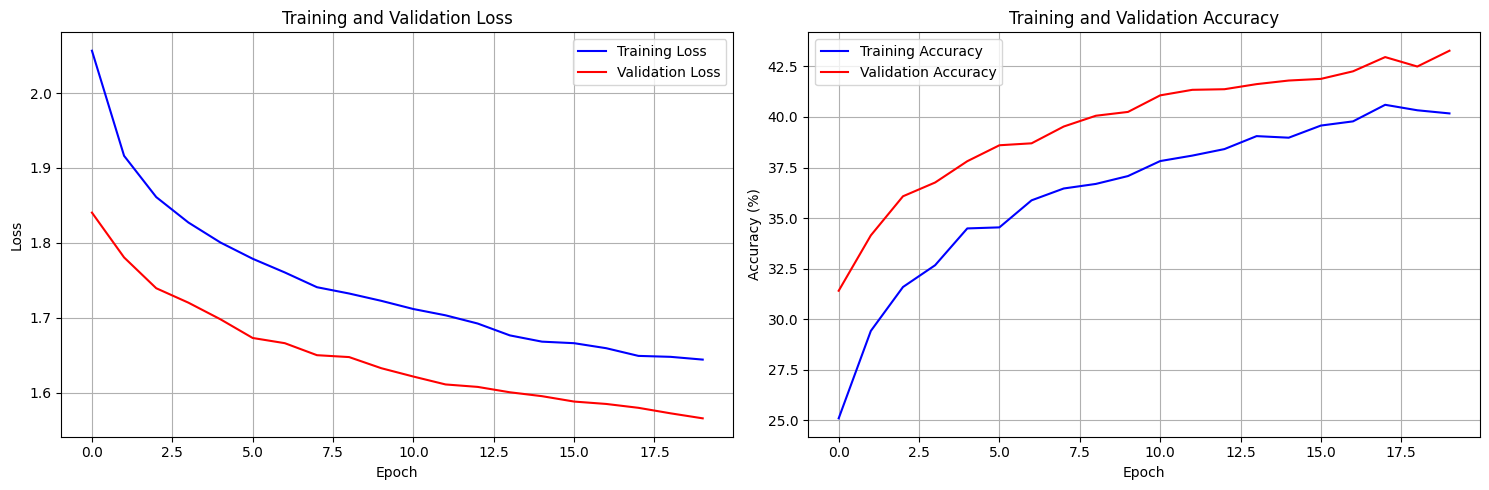

Training history plotted.

✅ test completed!
Final validation accuracy: 43.27%
This was just 30.0% of data - expect higher accuracy with full dataset

Logged training history to: ./drive/MyDrive/DL/experiment_logs/lr_0.01_epochs_20_20250919_220748_training_history.csv
Logged experiment summary to: ./drive/MyDrive/DL/experiment_logs/lr_0.01_epochs_20_20250919_220748_summary.txt
Results logged.


In [14]:
if __name__ == "__main__":
    # Initialize classifier
    classifier = ToolClassifier()
    classifier = test_run(path,epochs=20, subset_fraction=0.3, learning_rate=0.01)
